In [1]:
from pyspark import SparkContext
try:
    sc.stop() #停止以前的SparkContext，要不然下面创建工作会失败
except:
    pass
sc = SparkContext('local[2]', 'movieLens')
#spark://master:7077

In [2]:
import time
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.5"
user_data = sc.textFile('hdfs://master:9000/movieLens/ml-100k/u.user')
print(user_data.take(5))

['1|24|M|technician|85711', '2|53|F|other|94043', '3|23|M|writer|32067', '4|24|M|technician|43537', '5|33|F|other|15213']


## 数据探索及可视化

**统计用户、性别、职业和邮编的数目**

In [6]:
time_start = time.time()

user_fields = user_data.map(lambda line: line.split('|'))
num_users = user_fields.map(lambda fields: fields[0]).count()   #统计用户数
num_genders = user_fields.map(lambda fields : fields[2]).distinct().count()   #统计性别个数
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count()   #统计职业个数
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count()   #统计邮编个数
print("Users: %d, genders: %d, occupations: %d, ZIP codes: %d"%(num_users,num_genders,num_occupations,num_zipcodes))

time_end = time.time()
print(time_end - time_start)

Users: 943, genders: 2, occupations: 21, ZIP codes: 795
0.6485605239868164


**画出用户的年龄分布图**

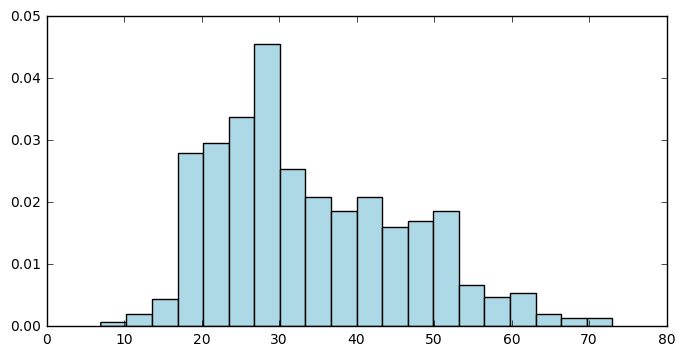

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
ages = user_fields.map(lambda x: int(x[1])).collect()
plt.hist(ages, bins=20, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

**画出用户的职业分布图**

[('engineer', 67), ('scientist', 31), ('homemaker', 7), ('doctor', 7), ('technician', 27), ('administrator', 79), ('librarian', 51), ('student', 196), ('healthcare', 16), ('programmer', 66), ('entertainment', 18), ('other', 105), ('executive', 32), ('none', 9), ('lawyer', 12), ('marketing', 26), ('artist', 28), ('retired', 14), ('salesman', 12), ('educator', 95), ('writer', 45)]


<function matplotlib.pyplot.show>

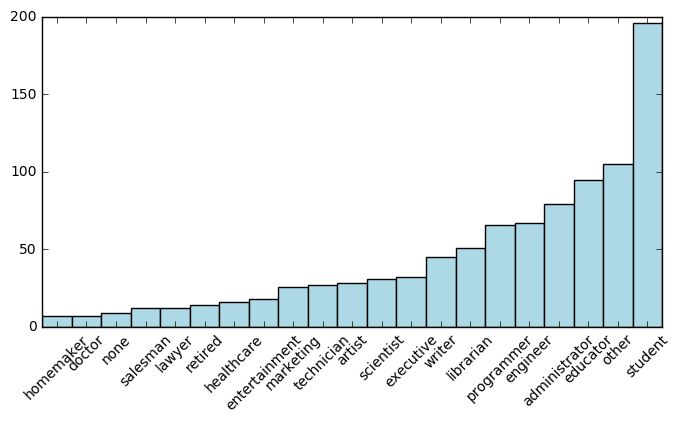

In [20]:
import numpy as np
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect()
print(count_by_occupation)
x_axis1 = np.array([c[0] for c in count_by_occupation])
y_axis1 = np.array([c[1] for c in count_by_occupation])
x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show

**Spark对RDD提供了一个名为countByValue的便捷函数。它会计算RDD里各不同值所分别出现的次数,并将其以Python dict函数的形式(或是Scala、Java下的Map函数)返回给驱动程序:**

In [22]:
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue()
print("Map-reduce approach:")
print(dict(count_by_occupation2))
print("========================" )
print("countByValue approach:")
print(dict(count_by_occupation))

Map-reduce approach:
{'librarian': 51, 'artist': 28, 'scientist': 31, 'salesman': 12, 'marketing': 26, 'student': 196, 'writer': 45, 'lawyer': 12, 'entertainment': 18, 'other': 105, 'technician': 27, 'educator': 95, 'homemaker': 7, 'none': 9, 'healthcare': 16, 'programmer': 66, 'engineer': 67, 'retired': 14, 'executive': 32, 'administrator': 79, 'doctor': 7}
countByValue approach:
{'writer': 45, 'librarian': 51, 'salesman': 12, 'programmer': 66, 'artist': 28, 'engineer': 67, 'healthcare': 16, 'scientist': 31, 'student': 196, 'marketing': 26, 'executive': 32, 'lawyer': 12, 'entertainment': 18, 'educator': 95, 'other': 105, 'technician': 27, 'doctor': 7, 'none': 9, 'homemaker': 7, 'retired': 14, 'administrator': 79}


In [23]:
movie_data = sc.textFile('hdfs://master:9000/movieLens/ml-100k/u.item')
print(movie_data.first())
num_movies = movie_data.count()
print("Movies: %d" %num_movies)

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


**画出电影的age分布图**

1681


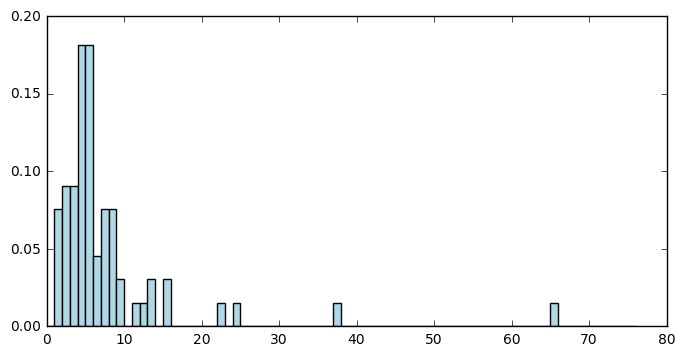

In [72]:
def convert_year(x):
    try:
        return int(x[-4:])
    except:
        return 1900
    
movie_fields = movie_data.map(lambda line: line.split('|'))
years = movie_fields.map(lambda field: field[2]).map(lambda x: convert_year(x))
years_filtered = years.filter(lambda x: x != 1900)
print(years_filtered.count())
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = list(movie_ages.values())
bins = list(movie_ages.keys())

plt.hist(values, bins, color='lightblue', normed=True)
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

In [76]:
rating_data = sc.textFile('hdfs://master:9000/movieLens/ml-100k/u.data')
print(rating_data.first())
num_ratings = rating_data.count()
print("Rating: %d" % num_ratings)

196	242	3	881250949
Rating: 100000


**对评分数据做一些基本的统计**

In [82]:
rating_data = rating_data.map(lambda line: line.split('\t'))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / num_ratings
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print('Min rating: %d' %min_rating)
print('max rating: %d' % max_rating)
print('Average rating: %2.2f' %mean_rating)
print('Median rating: %d '%median_rating)
print('Average # of ratings per user: %2.2f'%ratings_per_user)
print('Average # of ratings per movie: %2.2f' % ratings_per_movie)

Min rating: 1
max rating: 5
Average rating: 3.53
Median rating: 4 
Average # of ratings per user: 106.04
Average # of ratings per movie: 59.45


In [64]:
ratings.stats()

(count: 100000, mean: 3.529859999999947, stdev: 1.12566797076, max: 5.0, min: 1.0)

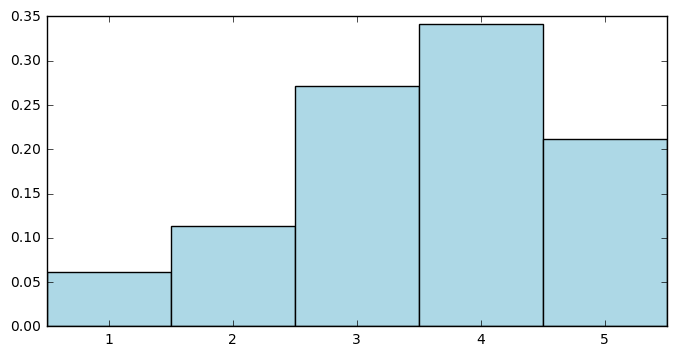

In [71]:
count_by_rating = ratings.countByValue()
x_axis = np.array(list(count_by_rating.keys()))
y_axis = np.array(list([float(c) for c in count_by_rating.values()]))
y_axis_normed = y_axis / y_axis.sum()
pos = np.arange(len(x_axis))
width = 1.0
ax = plt.axes()
ax.set_xticks(pos + width / 2)
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
fig = plt.gcf()
fig.set_size_inches(8, 4)
plt.show()

**计算每个用户相应的评价次数**

In [117]:
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey()
user_rating_byuser = user_ratings_grouped.map(lambda x: (x[0],len(x[1])))
print(user_rating_byuser.take(5))

[(1, 272), (2, 62), (3, 54), (4, 24), (5, 175)]


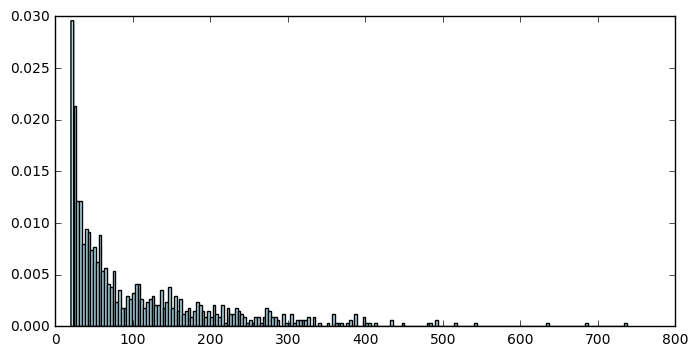

In [119]:
user_ratings_byuser_local = user_rating_byuser.map(lambda x: x[1]).collect()
plt.hist(user_ratings_byuser_local, bins=200, color = 'lightblue',normed = True)
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.show()

**计算每部电影受到的评论次数**

In [122]:
movie_ratings_group = rating_data.map(lambda fields: (int(fields[1]),int(fields[2]))).groupByKey()
movie_ratings_byuser = movie_ratings_group.map(lambda x: (x[0], len(x[1])))
print(movie_ratings_byuser.take(5))

[(1, 452), (2, 131), (3, 90), (4, 209), (5, 86)]


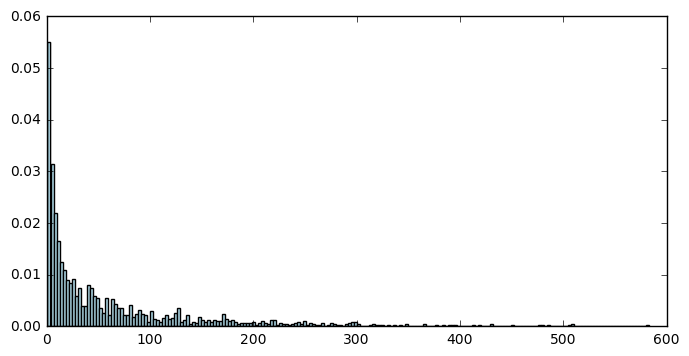

In [123]:
movie_ratings_byuser_local = movie_ratings_byuser.map(lambda x: x[1]).collect()
plt.hist(movie_ratings_byuser_local, bins=200, color = 'lightblue',normed = True)
fig = plt.gcf()
fig.set_size_inches(8,4)
plt.show()

---

## 数据处理与转换

**用指定值替换bad value和missing value**

In [127]:
years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).collect()
years_pre_processed_array = np.array(years_pre_processed)
mean_year = np.mean(years_pre_processed_array[years_pre_processed_array!=1900])
median_year = np.median(years_pre_processed_array[years_pre_processed_array!=1900])
index_bad_data = np.where(years_pre_processed_array==1900)
years_pre_processed_array[index_bad_data] = median_year
print('Mean year of release: %d' % mean_year)
print('Median year of release: %d ' % median_year)
print("Index of '1900' after assigning median: %s"% np.where(years_pre_processed_array==1900)[0])

Mean year of release: 1989
Median year of release: 1995 
Index of '1900' after assigning median: []
